In [2]:
from transformers import AutoImageProcessor, AutoModel
from annoy import AnnoyIndex
import torch
import cv2
from sklearn.model_selection import train_test_split


import numpy as np
import os
import shutil
import tqdm
import pickle
from torchvision.datasets import ImageFolder
import torchvision

import matplotlib.pyplot as plt
np.random.seed(42)

c:\gr\TestTask\.conda\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Prepare data

In [3]:
if os.path.exists("data_split"):
    with open("data_split/train_paths.pkl", "rb") as f:
        train_paths = pickle.load(f)
    
    with open("data_split/test_paths.pkl", "rb") as f:
        test_paths = pickle.load(f)
    with open("data_split/train_targets.pkl", "rb") as f:
        train_targets = pickle.load(f)
    with open("data_split/test_targtes.pkl", "rb") as f:
        test_targtes = pickle.load(f)
else:
    targets = []
    paths = []

    for folder in os.listdir("./flowers"):
        targets.extend([folder] * len(os.listdir(os.path.join("./flowers", folder))))
        paths.extend(
            [
                os.path.join("./flowers", folder, file)
                for file in os.listdir(os.path.join("./flowers", folder))
            ]
        )

    train_paths, test_paths, train_targets, test_targtes = train_test_split(
        paths, targets, test_size=0.2, stratify=targets, shuffle=True, random_state=42
    )

    if not os.path.exists("data_split"):
        os.mkdir("data_split")

    for f_name, f_obj in zip(
        ["train_paths", "test_paths", "train_targets", "test_targtes"],
        [train_paths, test_paths, train_targets, test_targtes],
    ):
        with open(f"data_split/{f_name}.pkl", "wb") as f:
            pickle.dump(f_obj, f)

In [4]:
if not os.path.exists("ds"):
    os.mkdir("ds")
    os.mkdir("ds/train")
    os.mkdir("ds/test")
    for folder in np.unique(train_targets):
        os.mkdir(f"ds/train/{folder}")
        os.mkdir(f"ds/test/{folder}")

    for file in train_paths:
        shutil.copy(file, os.path.join("ds\\train", file[10:]))

    for file in test_paths:
        shutil.copy(file, os.path.join("ds\\test", file[10:]))

# Feature extraction

## Pretrained 

In [5]:
preprocess = AutoImageProcessor.from_pretrained("facebook/dinov2-small", device="cuda:0")
model = AutoModel.from_pretrained("facebook/dinov2-small")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [6]:
if not os.path.exists("test_dino.ann"):
    with torch.no_grad():
        embeddings_train = []
        for path in tqdm.tqdm(train_paths):
            embeddings_train.append(
                model(
                    **preprocess(
                        cv2.imread(path),
                        return_tensors="pt",
                    )
                ).pooler_output
            )
            
        embeddings_test = []
        for path in tqdm.tqdm(test_paths):
            embeddings_test.append(
                model(
                    **preprocess(
                        cv2.imread(path),
                        return_tensors="pt",
                    )
                ).pooler_output
            )
    embeddings_train = torch.concat(embeddings_train, dim=0)
    embeddings_test = torch.concat(embeddings_test, dim=0)

## Self made

In [7]:
import torch.utils.data.dataloader


base_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((256, 256)),
    torchvision.transforms.ToTensor()
])

train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ColorJitter((0,0.2)),
    torchvision.transforms.RandomHorizontalFlip(),
    base_transforms
])

train_ds = ImageFolder("ds\\train", transform=train_transforms)
test_ds = ImageFolder("ds\\test", base_transforms)

train_dl = torch.utils.data.DataLoader(train_ds, batch_size=64, shuffle=True)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=64)

In [8]:
class FeatureExtractionModel(torch.nn.Module):

    def __init__(self):
        super().__init__()

        self.feature_extraction = torch.nn.Sequential(
            torch.nn.Conv2d(3, 10, kernel_size=5),
            torch.nn.MaxPool2d(2),
            torch.nn.ReLU(),
            torch.nn.Conv2d(10, 30, kernel_size=5),
            torch.nn.MaxPool2d(2),
            torch.nn.ReLU(),
            torch.nn.Conv2d(30, 50, kernel_size=5),
            torch.nn.MaxPool2d(2),
            torch.nn.ReLU(),
            torch.nn.Conv2d(50, 80, kernel_size=5),
            torch.nn.MaxPool2d(2),
            torch.nn.ReLU(),
            torch.nn.Conv2d(80, 120, kernel_size=5),
        )

        self.head = torch.nn.Sequential(
            torch.nn.Linear(120, 60),
            torch.nn.ReLU(),
            torch.nn.Linear(60, 5),
            torch.nn.Softmax(dim=-1)
        )

    def forward(self, x):
        features = self.feature_extraction(x).mean(dim=[-1, -2])
        return features, self.head(features)


In [9]:
model = FeatureExtractionModel().to(device="cuda:0")
optim = torch.optim.Adam(model.parameters())
loss_func = torch.nn.CrossEntropyLoss()

In [10]:
if not os.path.exists("custom_model.pt"):
    with tqdm.trange(400) as epoch_tqdm: 
        for epoch in epoch_tqdm:

            for x, y in train_dl:

                x = x.to(device="cuda:0")
                y = y.to(device="cuda:0")
                optim.zero_grad()
                fe, pred = model(x)

                loss = loss_func(pred, y)

                loss.backward()
                optim.step()

            with torch.no_grad():
                correct = 0
                d_len = 0
                for x, y in test_dl:
                    x = x.to(device="cuda:0")
                    fe, pred = model(x)
                    d_len += len(y)
                    correct += (pred.cpu().argmax(dim=-1) == y).sum()
            epoch_tqdm.desc = f"Acc: {correct/d_len:.3f}"

    torch.save(model.state_dict(), "custom_model.pt")

In [17]:
c_m = FeatureExtractionModel()
c_m.load_state_dict(torch.load("custom_model.pt"))

<All keys matched successfully>

In [22]:
img.shape

torch.Size([256, 256, 3])

In [29]:
embeddings_test = []
with torch.no_grad():
    for file in tqdm.tqdm(test_paths):
        img = torch.Tensor(
            np.moveaxis(
                cv2.resize(
                    cv2.imread(file), 
                    (256, 256)
                ),
                -1, 
                0
            )
        )
        f, p = c_m(img)
        embeddings_test.append(f[None])
embeddings_test = torch.cat(embeddings_test, dim=0)

100%|██████████| 864/864 [00:07<00:00, 120.51it/s]


# Nearest Neighbours

In [30]:
ann = AnnoyIndex(embeddings_test.shape[1], 'angular')

In [31]:
for i, em in enumerate(embeddings_test):
    ann.add_item(i, em)

In [32]:
ann.build(n_trees=5)

True

In [33]:
ann.save("test_custom.ann")

True

# Evaluation

In [ ]:
ann_dino = AnnoyIndex(384, 'angular')
ann_dino.load("test_dino.ann")

True

In [51]:
ann_custom = AnnoyIndex(120, "angular")
ann_custom.load("test_custom.ann")

True

In [53]:
ann = ann_custom

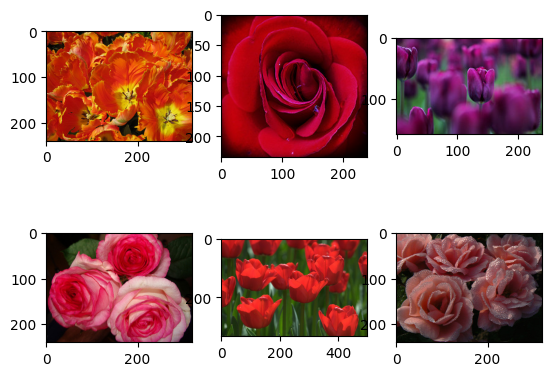

In [55]:
nn_index = ann.get_nns_by_item(np.random.randint(0, len(test_paths)), n=6)
fig, ax = plt.subplots(2, 3)

for i in range(2):
    for j in range(3):
        ax[i][j].imshow(cv2.imread(test_paths[nn_index[i * 3 + j]])[...,::-1])

plt.show()